In [13]:
#f'(x[i]) = (f(x[i+1]) - f(x[i]))/ step

import pandas as pd


#discretisation

def euler(beta, gama, mu):

    S = [0.99]
    I = [0.01]
    R = [0]
    D = [0]
    time = [0]
    step = 0.01

    for _ in range(1, 10000):
        time_update = time[-1] + step

        S_update = (-beta * S[-1] * I[-1])* step + S[-1]
        I_update = (beta * S[-1] * I[-1] - (gama * I[-1]) - mu * I[-1])* step + I[-1]
        R_update = (gama * I[-1])* step + R[-1]
        D_update = (mu * I[-1])* step + D[-1]

        S.append(S_update)
        I.append(I_update)
        R.append(R_update)
        D.append(D_update)
        time.append(time_update)
    dataframe = pd.DataFrame({'Time': time, 'Susceptibles': S, 'Infectés': I, 'Rétablis': R, 'Décès': D})
    return dataframe

In [14]:
"""beta = 0.5
gama = 0.15
mu = 0.015

pred_data = euler(beta, gama, mu)
pd.set_option('display.max_rows', None)  # Display all rows
print(pred_data)    """

"beta = 0.5\ngama = 0.15\nmu = 0.015\n\npred_data = euler(beta, gama, mu)\npd.set_option('display.max_rows', None)  # Display all rows\nprint(pred_data)    "

In [15]:
# on choisi mse car on fait un regression lineaire et non pas un classification


In [16]:
"""# Calculate the mean of every 100 rows
predicted_data = pred_data.groupby(pred_data.index // 100).mean()

predicted_data['Jour'] = predicted_data.index
predicted_data = predicted_data[["Jour", "Susceptibles", "Infectés", "Rétablis", "Décès"]]

print(predicted_data)"""


'# Calculate the mean of every 100 rows\npredicted_data = pred_data.groupby(pred_data.index // 100).mean()\n\npredicted_data[\'Jour\'] = predicted_data.index\npredicted_data = predicted_data[["Jour", "Susceptibles", "Infectés", "Rétablis", "Décès"]]\n\nprint(predicted_data)'

In [17]:
real_data = pd.read_csv('sird_dataset.csv')

In [18]:
"""min_size = min(len(real_data), len(predicted_data))
real_data = real_data.iloc[:min_size]
predicted_data = predicted_data.iloc[:min_size]"""

'min_size = min(len(real_data), len(predicted_data))\nreal_data = real_data.iloc[:min_size]\npredicted_data = predicted_data.iloc[:min_size]'

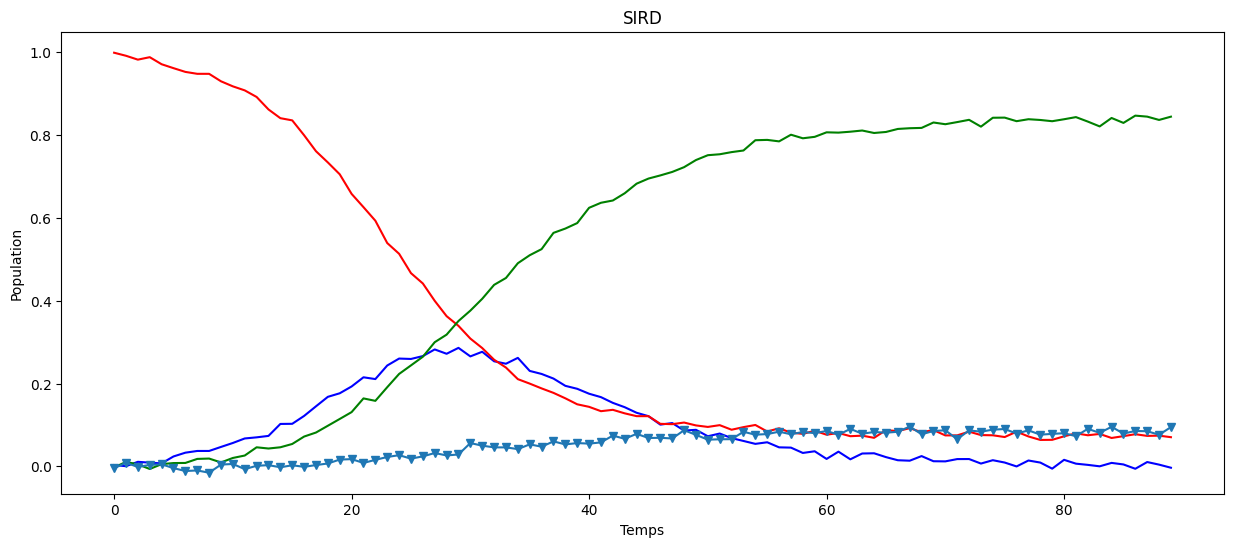

In [19]:
import matplotlib.pyplot as plt

def plot_data(data):
    plt.figure(figsize=(15, 6))
    plt.plot(data['Jour'], data['Infectés'], "b-", label = 'I')
    plt.plot(data['Jour'], data['Susceptibles'], "r-", label = 'S')
    plt.plot(data['Jour'], data['Rétablis'], "g-", label = 'R')
    plt.plot(data['Jour'], data['Décès'], "v-", label = 'D')
    plt.xlabel('Temps')
    plt.ylabel('Population')
    plt.title('SIRD')
    plt.show()

plot_data(real_data)

In [20]:
"""from sklearn.metrics import mean_squared_error
# on peut faire un mse general car on a mis tous les variable sur un echele
mse = ((real_data - predicted_data) ** 2).mean()
total_mse = mse.sum()

total_mse
"""

'from sklearn.metrics import mean_squared_error\n# on peut faire un mse general car on a mis tous les variable sur un echele\nmse = ((real_data - predicted_data) ** 2).mean()\ntotal_mse = mse.sum()\n\ntotal_mse\n'

In [21]:
import numpy as np
from tqdm.contrib.itertools import product

def grid_search(real_data):
    # Génération des valeurs possibles pour β, γ, et μ
    betas = np.linspace(0.25, 0.5, 4)   # β varie de 0.25 à 0.5
    gamas = np.linspace(0.08, 0.15, 4)  # γ varie de 0.08 à 0.15
    mus = np.linspace(0.005, 0.015, 4)  # μ varie de 0.005 à 0.015
    
    # Initialisation des meilleures valeurs pour β, γ, et μ
    best_beta, best_mu, best_gama = None, None, None
    best_mse = float("inf")  # Initialisation de la meilleure MSE (erreur quadratique moyenne)

    # Boucle sur toutes les combinaisons de β, γ, et μ
    for beta, gama, mu in product(betas, gamas, mus):
        # Prédiction des données avec les paramètres actuels
        predicted_data = euler(beta, gama, mu)
        
        # Agrégation des données prédictives par jour (chaque 100 lignes correspondent à un jour)
        predicted_data = predicted_data.groupby(predicted_data.index // 100).mean()
        
        # Mise à jour des indices pour correspondre à l'échelle et la longueur des données réelles
        predicted_data['Jour'] = predicted_data.index
        predicted_data = predicted_data[["Jour", "Susceptibles", "Infectés", "Rétablis", "Décès"]]
        
        # Ajustement de la taille des deux datasets pour avoir la même longueur
        min_size = min(len(real_data), len(predicted_data))
        real_data = real_data.iloc[:min_size]  # Redimensionnement des données réelles
        predicted_data = predicted_data.iloc[:min_size]  # Redimensionnement des données prédites
        
        # Calcul de la MSE (erreur quadratique moyenne) pour comparer les deux jeux de données
        mse = ((real_data - predicted_data) ** 2).mean()
        actual_mse = mse.sum()  # Somme des MSE pour tous les éléments
        
        # Si la MSE actuelle est meilleure (plus petite) que la meilleure MSE trouvée
        if actual_mse < best_mse:
            best_mse = actual_mse  # Mise à jour de la meilleure MSE
            best_beta, best_gama, best_mu = beta, gama, mu  # Mise à jour des meilleurs paramètres

    # Affichage des meilleurs paramètres
    print(best_beta, best_gama, best_mu)

    # Calcul des prédictions avec les meilleurs paramètres
    best_predicted_data = euler(best_beta, best_gama, best_mu)
    predicted_data = best_predicted_data.groupby(best_predicted_data.index // 100).mean()
    predicted_data['Jour'] = predicted_data.index
    predicted_data = predicted_data[["Jour", "Susceptibles", "Infectés", "Rétablis", "Décès"]]
    
    # Redimensionnement des données prédites pour correspondre à la taille des données réelles
    predicted_data = predicted_data.iloc[:min_size]
    
    # Visualisation des données réelles et prédites
    plot_data(real_data)
    plot_data(predicted_data)
    
    # Retourner les données prédites avec les meilleurs paramètres
    return predicted_data


  0%|          | 0/64 [00:00<?, ?it/s]

100%|██████████| 64/64 [00:03<00:00, 17.06it/s]


0.25 0.08 0.005


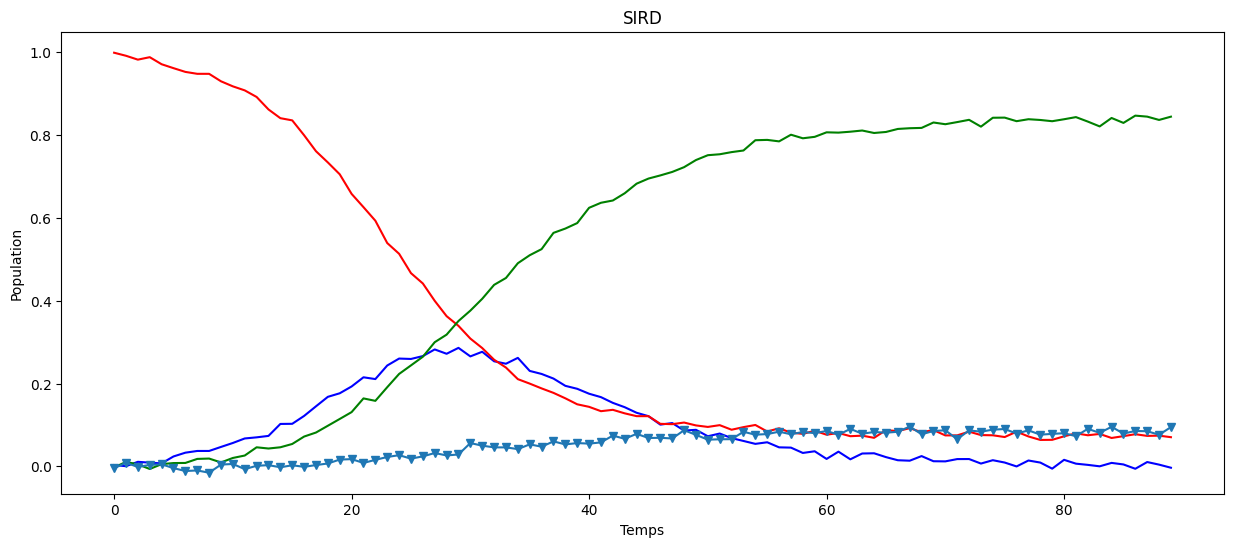

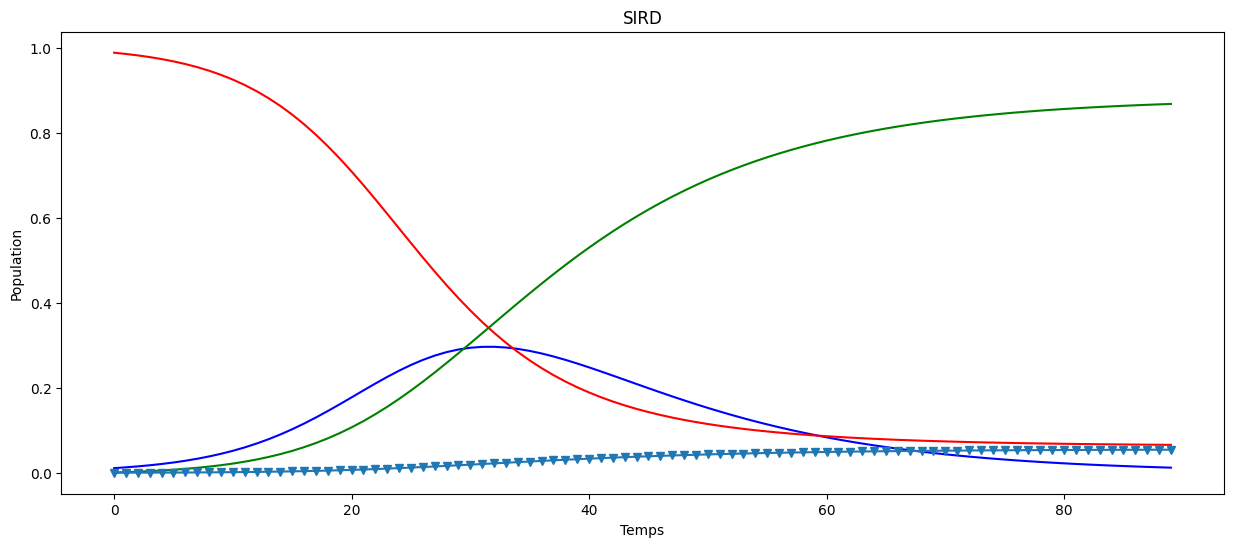

,Jour,Susceptibles,Infectés,Rétablis,Décès
0,0,0.988708,0.010848,0.000418,0.000026
1,1,0.985805,0.012751,0.001359,0.000085
2,2,0.982404,0.014977,0.002465,0.000154
3,3,0.978426,0.017576,0.003763,0.000235
4,4,0.973781,0.020603,0.005286,0.000330
...,...,...,...,...,...
85,85,0.066542,0.015732,0.863742,0.053984
86,86,0.066290,0.014691,0.864959,0.054060
87,87,0.066055,0.013719,0.866095,0.054131
88,88,0.065836,0.012810,0.867156,0.054197


In [22]:
grid_search(real_data)

In [23]:
'''
β  : Taux de transmission de la maladie (probabilité de transmission par contact)
γ  : Taux de guérison (et d'immunisation)
μ  : Taux de mortalité dû à la maladie

1- Quand R inferieur a 1 donc la courbes d'infection descendera et si R est superieur a 1 
le taux d'infection montera rapidement puisuqe y a beacoup de mort et de guerison


'''

"\nβ  : Taux de transmission de la maladie (probabilité de transmission par contact)\nγ  : Taux de guérison (et d'immunisation)\nμ  : Taux de mortalité dû à la maladie\n\n1- Quand R inferieur a 1 donc la courbes d'infection descendera et si R est superieur a 1 \nle taux d'infection montera rapidement puisuqe y a beacoup de mort et de guerison\n\n\n"

In [24]:
# on met un petit beta

print(euler(0.8, 0.08, 0.005))

#on remarque que quand on change beta R sera inférieur a 1 donc l'epidemie se stabilise

       Time  Susceptibles  Infectés  Rétablis         Décès
0      0.00      0.990000  0.010000  0.000000  0.000000e+00
1      0.01      0.989921  0.010071  0.000008  5.000000e-07
2      0.02      0.989841  0.010142  0.000016  1.003535e-06
3      0.03      0.989761  0.010214  0.000024  1.510630e-06
4      0.04      0.989680  0.010286  0.000032  2.021309e-06
...     ...           ...       ...       ...           ...
9995  99.95      0.000080  0.000366  0.940756  5.879727e-02
9996  99.96      0.000080  0.000366  0.940757  5.879729e-02
9997  99.97      0.000080  0.000366  0.940757  5.879730e-02
9998  99.98      0.000080  0.000365  0.940757  5.879732e-02
9999  99.99      0.000080  0.000365  0.940757  5.879734e-02

[10000 rows x 5 columns]
